# 画像認識と深層学習

今回は，MNISTと呼ばれる教室つき画像データを利用して，画像認識のための機械学習処理を体験します．
PyTorchと呼ばれるライブラリを利用すると，簡単に試すことができます．

プログラムが具体的に何をしているかまでは説明しませんが，機械学習の処理が何を利用して，何を対象に実行しているかは，随時説明してあります．
参考記事：[PyTorchの使い方](https://dreamer-uma.com/pytorch-mlp-mnist/)

まずは人工知能ライブラリでも現在最も人気のある一つ，PyTorchを使う準備をします．

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# グラフのスタイルを指定
plt.style.use('seaborn-darkgrid')

次は機械学習のための画像データMNISTの準備です．
PyTorchにはあらかじめ組み込まれているので，どこかからダウンロードして入手する，のような手間は不要です．
若干の実行時間がかかります．

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## MNISTデータを確認する

MNISTとは，どのようなデータなのでしょうか．
それは28X28ピクセルの2値（白黒と思ってよい）画像データとラベル（数字0から9までの10通り）からなるデータです．
少し描かせてみましょう．

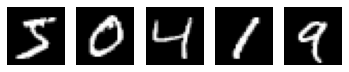

In [4]:
fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
    axes[i].axis("off")

手書きの数字データですね．
これを機械学習利用するために，ちょっとした加工をします．

In [5]:
batch_size = 256


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

## 機械学習モデルの構築

学習用データの準備ができたので機械学習モデルの準備をします．
ニュース記事のほとんどでは，技術系のものであっても，具体的にどんな機械学習かまでは説明されていないことがふつうです．
ここで作成するモデルが特別の意味をもつわけではありませんが，初心者にとって扱いやすいものにしてあります．

詳しい解説はしませんが，変数名にNNの文字があるのは，深層学習を行うニューラルネットワークの頭文字を考慮してのものです．

In [6]:
num_classes = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)

準備ができたので機械学習を進めてみましょう．
まずは学習しない状態を見ます．

In [8]:
# 順伝搬の確認
input_samples = torch.randn(5, 784, device=device)
output_samples = model(input_samples)
print(output_samples.size())

torch.Size([5, 10])


学習には誤差がつきものです．
その誤差のあり方を定義します．
専門家の工夫が強く現れるところですが，今回は実行デモが目的なので，とくに説明はしません．

In [9]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定
optimizer = optim.SGD(model.parameters(), lr=0.01)

学習の進行を制御するための関数を定義します．

In [10]:
def train_fn(model, train_loader, criterion, optimizer, device='cpu'):
    
    # 1epoch training 
    train_loss = 0.0
    num_train = 0

    # model 学習モードに設定
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        # batch数を累積
        num_train += len(labels)
        
        # viewで1次元配列に変更
        # toでgpuに転送
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        # 勾配をリセット
        optimizer.zero_grad()
        # 推論
        outputs = model(images)
        # lossを計算
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward()
        # パラメータ更新
        optimizer.step()
        # lossを累積
        train_loss += loss.item()
        
    train_loss = train_loss/num_train

    return train_loss
    
def valid_fn(model, train_loader, criterion, optimizer, device='cpu'):
    
    # 評価用のコード
    valid_loss = 0.0
    num_valid = 0

    # model 評価モードに設定
    model.eval()

    # 評価の際に勾配を計算しないようにする
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            num_valid += len(labels)
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
           
        valid_loss = valid_loss/num_valid

    return valid_loss
    
def run(model, train_loader, test_loader, criterion, optimizer, device='cpu'):

    train_loss_list = []
    valid_loss_list = []

    for epoch in range(num_epochs):

        _train_loss = train_fn(model, train_loader, criterion, optimizer, device=device)
        _valid_loss = valid_fn(model, train_loader, criterion, optimizer, device=device)

        print(f'Epoch [{epoch+1}], train_Loss : {_train_loss:.5f}, val_Loss : {_valid_loss:.5f}')
        
        train_loss_list.append(_train_loss)
        valid_loss_list.append(_valid_loss)

    return train_loss_list, valid_loss_list

お待たせしました．
実行です．
実行時間（文字入力でよい）をレポートしてください．
この説明を準備したときは7分17秒でした．

どこに表示されるかはeALPSに置いた画像を参考にしてください．

In [13]:
num_epochs = 20
train_loss_list, test_loss_list = run(model, train_loader, test_loader, criterion, optimizer, device=device)

Epoch [1], train_Loss : 0.00872, val_Loss : 0.00844
Epoch [2], train_Loss : 0.00728, val_Loss : 0.00592
Epoch [3], train_Loss : 0.00450, val_Loss : 0.00342
Epoch [4], train_Loss : 0.00291, val_Loss : 0.00247
Epoch [5], train_Loss : 0.00227, val_Loss : 0.00203
Epoch [6], train_Loss : 0.00194, val_Loss : 0.00178
Epoch [7], train_Loss : 0.00174, val_Loss : 0.00162
Epoch [8], train_Loss : 0.00161, val_Loss : 0.00151
Epoch [9], train_Loss : 0.00151, val_Loss : 0.00142
Epoch [10], train_Loss : 0.00144, val_Loss : 0.00137
Epoch [11], train_Loss : 0.00138, val_Loss : 0.00131
Epoch [12], train_Loss : 0.00133, val_Loss : 0.00127
Epoch [13], train_Loss : 0.00129, val_Loss : 0.00123
Epoch [14], train_Loss : 0.00126, val_Loss : 0.00120
Epoch [15], train_Loss : 0.00122, val_Loss : 0.00117
Epoch [16], train_Loss : 0.00119, val_Loss : 0.00114
Epoch [17], train_Loss : 0.00117, val_Loss : 0.00113
Epoch [18], train_Loss : 0.00114, val_Loss : 0.00110
Epoch [19], train_Loss : 0.00112, val_Loss : 0.00108
Ep

最後に学習成果を確認しましょう．
データを一つ取り出し判定してみます．
どうでしたか．

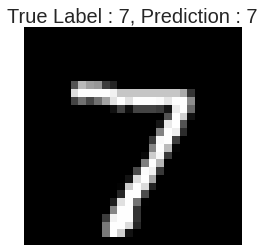

In [14]:
# datasetからサンプルを一つ取り出す
image, label = test_dataset[0]
image = image.view(-1, 28*28).to(device)

# 推論
prediction_label = torch.argmax(model(image))

fig, ax = plt.subplots()
ax.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')

ax.axis('off')
ax.set_title(f'True Label : {label}, Prediction : {prediction_label}', fontsize=20)

plt.show()